In [22]:
#importing libareris
import pandas as pd
import numpy as np
import os
#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For Transforming our target vatiable
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
#For preprocessing text data
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


Data Injection

In [23]:
path1='../AI/bugs.txt'
print(path1)
path2='../AI/comments.txt'
print(path2)
path3='../AI/complaints.txt'
print(path3)
path4='../AI/meaningless.txt'
print(path4)
path5='../AI/requests.txt'
print(path5)

../AI/bugs.txt
../AI/comments.txt
../AI/complaints.txt
../AI/meaningless.txt
../AI/requests.txt


In [24]:
def text_data(path):
    text_Body=[]
    with open(path, "r", encoding='windows-1256') as f:
        lines = f.readlines()
            #print(lines) 
        text_Body.append(lines)
    text_body_appended=[]
    for i in range(0,len(text_Body[0])):
        value=text_Body[0][i]
        text_body_appended.append(value)
    return text_body_appended

In [25]:
bugs=text_data(path1)
comments=text_data(path2)
complaints=text_data(path3)
meaningless=text_data(path4)
requests=text_data(path5)

Data Visualisation

In [26]:
print(len(bugs))
print(len(comments))
print(len(complaints))
print(len(meaningless))
print(len(requests))

72
1759
950
306
103


In [27]:
def data_frame(txt,category):
    column_names=('text','Category')
    df = pd.DataFrame(columns=column_names)
    df['text']=txt
    df['Category']=category
    return df

In [28]:
data=data_frame(bugs,"Bug")
data=data.append(data_frame(comments,"comments"))
data=data.append(data_frame(complaints,"complaints"))
data=data.append(data_frame(meaningless,"meaningless"))
data=data.append(data_frame(requests,"requests"))

In [29]:
data['Category'].unique()

array(['Bug', 'comments', 'complaints', 'meaningless', 'requests'],
      dtype=object)

In [30]:
data.head()

,text,Category
0,A lot of the time my purchase won't show up.\n,Bug
1,I only see the notification if I catch it live...,Bug
2,When I type the typing area should slide above...,Bug
3,"I ran it, and promptly got driver problems wit...",Bug
4,Still calls keep dropping with the new updates\n,Bug


In [31]:
data.groupby(['Category']).size()

Category
Bug              72
comments       1759
complaints      950
meaningless     306
requests        103
dtype: int64

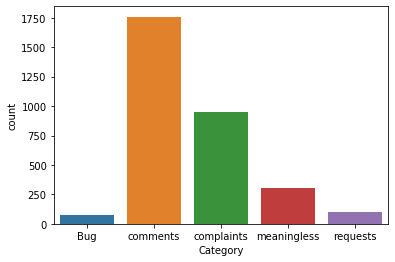

In [32]:
sns.countplot(x='Category',data=data,order=['Bug', 'comments', 'complaints', 'meaningless', 'requests'])
plt.show()

Data cleaning and preparation

In [33]:
#remove link starts with https
data['text'] = data['text'].map(lambda x:re.sub('http.*','',str(x)))
#removing data and time (numeric values)
data['text'] = data['text'].map(lambda x:re.sub('[0-9]','',str(x)))
#removing \n
data['text'] = data['text'].map(lambda x:re.sub('[\\n]','',str(x)))
#removing some special characters
data['text'] = data['text'].map(lambda x:re.sub('[#|*|$|:|\\|&]','',str(x)))

In [34]:
my_stopwords = ['jan','january','february' 'feb', 'march', 'april', 'may', 'june','july','aug',
                    'october','October','june','july','February','apr','Apr','february','jun','jul','feb','sep',
                    'august','sept','september','oct','october','nov','november','dec','december','mar','november october','wasnt']

In [42]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Isaac
[nltk_data]     Sadikin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [43]:
#preparing train data
#removing stopwords and tokenizing it.
stop=stopwords.words('english')
text=[]
none=data['text'].map(lambda x:text.append(' '.join
       ([word for word in str(x).strip().split() if not word in set(stop) and word not in my_stopwords])))
tfid=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None)
x_features=tfid.fit_transform(text).toarray()
x_features=pd.DataFrame(x_features)

Training
One vs all

In [44]:
#preparing target variable
target=data['Category']
label=LabelEncoder()
target=label.fit_transform(target)
target=to_categorical(target)

In [45]:
target=pd.DataFrame(data=target,columns=['Bug', 'comments', 'complaints', 'meaningless', 'requests'])
target.head()

,Bug,comments,complaints,meaningless,requests
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [46]:
#training with One Vs All(One VS Rest)
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression as lg
logistic=lg(penalty='l2',solver='newton-cg',C=5,multi_class='ovr',max_iter=5000)#using multiclass as ovr(one vs rest)

Training Bugs vs all

In [47]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[:144,:],y=target.iloc[:144,0],cv=5)
acc.mean()

0.8200000000000001

Training comments vs all

In [48]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[100:2100,:],y=target.iloc[100:2100,1],cv=5)
acc.mean()

0.8645083969274807

Training complaints vs all

In [49]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[1500:3500,:],y=target.iloc[1500:3500,2],cv=5)
acc.mean()

0.6124260355029586

Training meaningless vs all

In [50]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[2700:3300,:],y=target.iloc[2700:3300,3],cv=5)
acc.mean()

0.6941155718769857

Training requests vs all

In [51]:
acc=cross_val_score(estimator=logistic,X=x_features.iloc[-206:,:],y=target.iloc[-206:,4],cv=5)
acc.mean()

0.7230952380952381

can clearly see that 'comment' got the best accuracy (abour 87%) this is because of its the bigger data size which making our model inclined towards comments

Artificial Neural Network

In [52]:
#lets dig deeper and apply Deep learning for better accuracy
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import regularizers
from keras.layers import Dropout

In [53]:
x_features.shape

(3190, 5193)

Preparing target variable for ANN

In [54]:
#preparing target variable
target=data['Category']
label=LabelEncoder()
target=label.fit_transform(target)
target=to_categorical(target)

In [55]:
target=pd.DataFrame(data=target,columns=['Bug', 'comments', 'complaints', 'meaningless', 'requests'])
target.head()

,Bug,comments,complaints,meaningless,requests
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [56]:
clf=Sequential()
#adding layers to ANN
clf.add(Dense(units=2048,activation="relu",kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.001),input_dim=5193))
clf.add(Dropout(0.2))
#adding two more hidden layer to ANN
clf.add(Dense(units=2048,activation="relu",kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.001)))
clf.add(Dropout(0.2))
clf.add(Dense(units=2048,activation="relu",kernel_initializer="uniform",kernel_regularizer=regularizers.l2(0.001)))
clf.add(Dropout(0.2))
#adding output layer
clf.add(Dense(units=5,activation="softmax",kernel_initializer="uniform"))
#compiling ANN
clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [57]:
#fitting ANN
hist=clf.fit(x_features,target,batch_size=32,epochs=24)

Epoch 1/24
3190/3190 [==============================] - 38s 12ms/step - loss: 4.2267 - accuracy: 0.5853
Epoch 2/24
3190/3190 [==============================] - 36s 11ms/step - loss: 1.1163 - accuracy: 0.7229
Epoch 3/24
3190/3190 [==============================] - 37s 11ms/step - loss: 0.9071 - accuracy: 0.7987
Epoch 4/24
3190/3190 [==============================] - 34s 11ms/step - loss: 0.8068 - accuracy: 0.8404
Epoch 5/24
3190/3190 [==============================] - 34s 11ms/step - loss: 0.7359 - accuracy: 0.8592
Epoch 6/24
3190/3190 [==============================] - 35s 11ms/step - loss: 0.6855 - accuracy: 0.8708
Epoch 7/24
3190/3190 [==============================] - 34s 11ms/step - loss: 0.6086 - accuracy: 0.8962
Epoch 8/24
3190/3190 [==============================] - 34s 11ms/step - loss: 0.5540 - accuracy: 0.9041
Epoch 9/24
3190/3190 [==============================] - 34s 11ms/step - loss: 0.5122 - accuracy: 0.9154
Epoch 10/24
3190/3190 [==============================] - 34s 11m

Evaluation by Graph

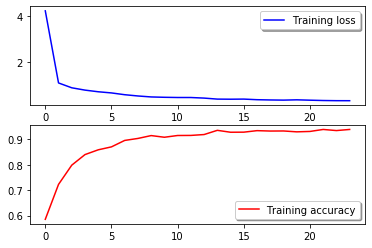

In [60]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='r', label="Training accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Prediction

In [61]:
test=["A lot of the time my purchase won't show up.\n",
      'There should be a Free Demo Mode :/\n',
      "App constantly crashes and looks like it was designed in 2009... Have to open the app multiple times before I get to a login screen, usually receiving a 'not responding' error.\n"]

In [62]:
test=pd.DataFrame(test,columns=['text'])

In [63]:
#remove link starts with https
test['text'] = test['text'].map(lambda x:re.sub('http.*','',str(x)))
#removing data and time (numeric values)
test['text'] = test['text'].map(lambda x:re.sub('[0-9]','',str(x)))
#removing some special characters
test['text'] = test['text'].map(lambda x:re.sub('[#|*|$|:|\\|&]','',str(x)))

In [64]:
#preparing data
#removing stopwords and tokenizing it.
stop=stopwords.words('english')
text=[]
none=test['text'].map(lambda x:text.append(' '.join
       ([word for word in str(x).strip().split() if not word in set(stop)])))
x_features_test=tfid.transform(text).toarray()
x_features_test=pd.DataFrame(x_features_test)

Predicting by ANN model

In [65]:
results=clf.predict(x_features_test)

In [66]:
# select the index with the maximum probability
results = np.argmax(results,axis = 1)
results

array([2, 4, 0], dtype=int64)

All predictions are correct

In [67]:
results=pd.DataFrame(results,columns=['Category'])
int_category={0:'Bug', 1:'comments', 2:'complaints', 3:'meaningless', 4:'requests'}
results['Category']=results['Category'].apply(lambda x:int_category[x])
results['text']=test['text']

In [68]:
results

,Category,text
0,complaints,A lot of the time my purchase won't show up.\n
1,requests,There should be a Free Demo Mode /\n
2,Bug,App constantly crashes and looks like it was d...


In [ ]:
#another test

In [78]:
test=["the room was comfortable.\n",
      'points reduced sigh :/\n']

In [79]:
test=pd.DataFrame(test,columns=['text'])

In [80]:
#remove link starts with https
test['text'] = test['text'].map(lambda x:re.sub('http.*','',str(x)))
#removing data and time (numeric values)
test['text'] = test['text'].map(lambda x:re.sub('[0-9]','',str(x)))
#removing some special characters
test['text'] = test['text'].map(lambda x:re.sub('[#|*|$|:|\\|&]','',str(x)))

In [81]:
#preparing data
#removing stopwords and tokenizing it.
stop=stopwords.words('english')
text=[]
none=test['text'].map(lambda x:text.append(' '.join
       ([word for word in str(x).strip().split() if not word in set(stop)])))
x_features_test=tfid.transform(text).toarray()
x_features_test=pd.DataFrame(x_features_test)

In [82]:
results=clf.predict(x_features_test)

In [83]:
# select the index with the maximum probability
results = np.argmax(results,axis = 1)
results

array([1, 3], dtype=int64)

In [84]:
results=pd.DataFrame(results,columns=['Category'])
int_category={0:'Bug', 1:'comments', 2:'complaints', 3:'meaningless', 4:'requests'}
results['Category']=results['Category'].apply(lambda x:int_category[x])
results['text']=test['text']

In [85]:
results

,Category,text
0,comments,the room was comfortable.\n
1,meaningless,points reduced sigh /\n
